In [2]:
import os
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)      # writer handle
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [4]:
def measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
        omega_i = Rb_si_sub @ omega
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas

In [5]:
def sim_QN(meas, gyro_range, accel_range, gyro_bits, accel_bits, num_imus):
    quantized_data = np.zeros(6*num_imus)
    quantization_noise = np.zeros(6*num_imus)
    for i in range(num_imus):
        accel_quantization_step = (2 * accel_range) / (2 ** accel_bits)
        gyro_quantization_step  = (2 * gyro_range) / (2 ** gyro_bits)
        quantized_data[i*6:3+i*6]   = np.round(meas[i*6:3+i*6] / accel_quantization_step) * accel_quantization_step # sf
        quantized_data[i*6+3:6+i*6] = np.round(meas[i*6+3:6+i*6] / gyro_quantization_step) * gyro_quantization_step # omega
        quantization_noise[i*6:6+i*6] = quantized_data[i*6:6+i*6] - meas[i*6:6+i*6]

    return quantized_data, quantization_noise

In [6]:
num_imus = 3

time = np.arange(0, 360, 0.01)
WN_STD    = 3.3e-3*np.ones(6*num_imus)
RW_STD    = 1.8e-4
B         = 3.3e-3
bias_var  = ((2 * B**2)/np.pi) * np.log(2)
gyro_bits = 16  # 16-bit ADC
accel_bits = 16  # 16-bit ADC
accel_range = 16  # Range of accelerometer in g's
gyro_range = 300  # Range of gyroscope in degrees/sec

WN = np.zeros((len(time), 18))
RW = np.zeros((len(time), 18))
rw = np.zeros((len(time), 18))
w_bias = np.zeros((len(time), 18))

for i in range(len(time)):
    WN[i,:] = np.random.normal(loc=0, scale=WN_STD, size=18)

for i in range(len(time)):
    rw[i,:] = np.random.normal(loc=0, scale=RW_STD, size=18)

for i in range(1, len(time)):
    RW[i,:] = RW[i-1,:] + rw[i-1,:]

for i in range(1, len(time)):
    w_bias[i,:] = np.random.normal(0, np.sqrt(bias_var))

In [7]:
filename = "data/imu.txt"

dt = 1e-2
angvel_magnitude = 1
num_steps = int(360/dt)
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])

omega = np.array([1, 1, 1])
omega_dot = np.array([0, 0, 0])
sf = np.array([0, 0, 1])

time = np.arange(0, 360, 0.01)
state = np.zeros(9 + 6*num_imus)
state[0:3] = omega
state[6:9] = sf
meas_hist = np.zeros((len(time),6*num_imus))
quantized_hist = np.zeros((len(time),6*num_imus))
QN_hist = np.zeros((len(time),6*num_imus))

for i in range(len(time)):
    meas = measurement(omega, omega_dot, sf, pos_r, Rb_si, num_imus)
    meas_noise = meas + RW[i] + WN[i] 
    quantized_data, QN = sim_QN(meas_noise, gyro_range, accel_range, gyro_bits, accel_bits, num_imus)
    meas_hist[i] = meas_noise
    quantized_hist[i] = quantized_data
    QN_hist[i] = QN
    
csv_write(quantized_hist, filename)

Text(0.5, 1.0, 'specific force measurements')

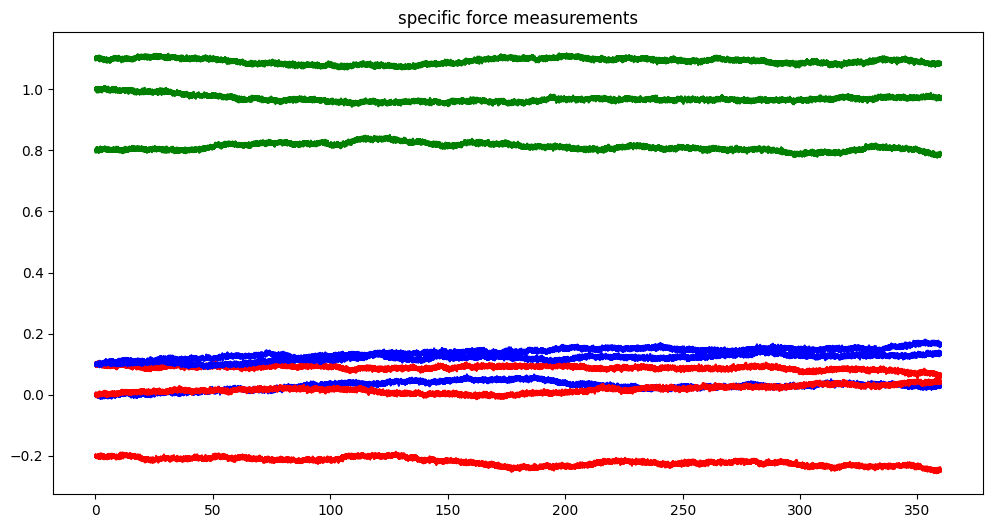

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(time, quantized_hist[:,0], color='blue')
plt.plot(time, quantized_hist[:,1], color='red')
plt.plot(time, quantized_hist[:,2], color='green')
plt.plot(time, quantized_hist[:,6], color='blue')
plt.plot(time, quantized_hist[:,7], color='red')
plt.plot(time, quantized_hist[:,8], color='green')
plt.plot(time, quantized_hist[:,12], color='blue')
plt.plot(time, quantized_hist[:,13], color='red')
plt.plot(time, quantized_hist[:,14], color='green')
plt.title("specific force measurements")

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(time, quantized_hist[:,3])
plt.plot(time, quantized_hist[:,4])
plt.plot(time, quantized_hist[:,5])
plt.plot(time, quantized_hist[:,9])
plt.plot(time, quantized_hist[:,10])
plt.plot(time, quantized_hist[:,11])
plt.plot(time, quantized_hist[:,15])
plt.plot(time, quantized_hist[:,16])
plt.plot(time, quantized_hist[:,17])
plt.title("angular rate measurements")

Text(0.5, 1.0, 'angular rate measurements')